### Read in Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import researchpy as rp

from descartes.patch import PolygonPatch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection

In [3]:
listings_detail = pd.read_excel('../CourseProject/data/listings_detail.xlsx', index_col=0)
calendar_detail = pd.read_excel('../CourseProject/data/calendar_detail.xlsx' , index_col=0)
neighbourhoods = pd.read_excel('../CourseProject/data/neighbourhoods.xlsx', index_col=0)
reviews = pd.read_excel('../CourseProject/data/reviews_detail.xlsx', index_col=0)
crime = pd.read_excel('../CourseProject/data/NYPD_Arrests_Data__Historic_.xlsx', index_col=0)
nbgeo = gpd.read_file('../CourseProject/data/neighbourhoods.geojson')
ls=pd.read_csv('../CourseProject/data/listings_summary.csv', index_col=0)

### Data Cleaning
There are many missing values which either need to be removed or estimated so that they do not affect our results

In [2]:
#How many records we start with
print(f'Number of records: {listings_detail.count()[0]}')

Number of records: 44317


In [87]:
#What is missing?
ls.isna().sum()

name                                28
host_id                              0
host_name                          232
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9440
reviews_per_month                 9474
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [91]:
#What is missing?
listings_detail.isna().sum()

listing_url                             1
scrape_id                               1
last_scraped                            1
name                                   40
summary                              1521
space                               14501
description                            30
experiences_offered                     1
neighborhood_overview               18695
notes                               28202
transit                             16963
access                              19105
interaction                         19941
house_rules                         19177
thumbnail_url                        3306
medium_url                           3306
picture_url                             1
xl_picture_url                       3306
host_id                                 1
host_url                                1
host_name                             232
host_since                            232
host_location                         405
host_about                        

In [23]:
#Fix NaN in review per month 

#Estimate attempt:
#Use to fill in missing values with median
def impute_median(series):
    return series.fillna(series.median())

listings_detail.loc['reviews_per_month']=listings_detail["reviews_per_month"].transform(impute_median)


#Remove records that do not have a room to offer
listings_detail=listings_detail[listings_detail['room_type'] != 0]

#Remove records that are "free"
listings_detail=listings_detail[listings_detail['price']!=0]

In [24]:
#How many records we have now
print(f'Number of records after cleaning: {listings_detail.count()[0]}')

Number of records after cleaning: 44267


### EDA 

In [41]:
#there's 202 unique neighborhoods - do we want to reduce this? how?
listings_detail['neighbourhood'].nunique()

203

In [32]:
ls=pd.read_csv('../CourseProject/data/listings_summary.csv', index_col=0)
ls.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
18461891,"Bright, comfortable 1B studio near everything!",916092,Connie Mae,Queens,Ditmars Steinway,40.774142,-73.916246,Entire home/apt,110,6,0,NaN,NaN,1,0
20702398,Quiet house on City Island,1457680,James,Bronx,City Island,40.849191,-73.786509,Private room,50,1,2,2017-10-01,2.00,1,169
6627449,Large 1 BDRM in Great location,13886510,Arlene,Bronx,City Island,40.849775,-73.786609,Entire home/apt,125,3,21,2017-09-26,0.77,1,363
19949243,Stay aboard a sailboat,1149260,MoMo,Bronx,City Island,40.848838,-73.782276,Entire home/apt,100,3,0,NaN,NaN,1,90
1886820,Quaint City Island Community.,9815788,Steve,Bronx,City Island,40.841144,-73.783052,Entire home/apt,300,7,0,NaN,NaN,1,365


### <b> Question 1: </b>
Is there a difference in the cost, popularity, and ratings for different areas? Do additional research to learn why.

#### Price

In [38]:
rp.summary_cont(ls['price'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,price,44317.0,147.675948,209.138888,0.993458,145.728753,149.623144


That gives us data by whole, but we really are interested in the data by neighbourhood

In [39]:
rp.summary_cont(ls['price'].groupby(ls['neighbourhood_group']))

,N,Mean,SD,SE,95% Conf.,Interval
neighbourhood_group,,,,,,
Bronx,791,88.910240,147.269875,5.236314,78.640571,99.179909
Brooklyn,18470,120.701624,178.882444,1.316238,118.121729,123.281520
Manhattan,20370,185.082867,233.717036,1.637551,181.873188,188.292546
Queens,4392,99.620674,174.882615,2.638855,94.447930,104.793418
Staten Island,294,126.517007,311.045103,18.140519,90.900967,162.133047


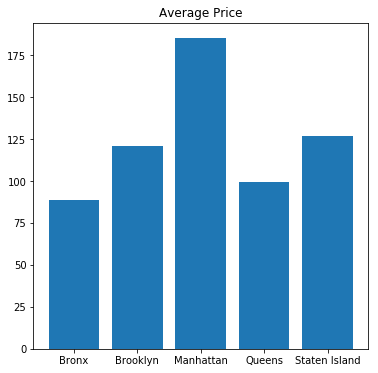

In [92]:
# Price
price_group = ls[["neighbourhood_group","price"]].groupby(["neighbourhood_group"]).price.mean()
plt.figure(figsize = (6,6))
plt.bar(range(len(price_group.values)),price_group.values)
plt.xticks(range(len(price_group.values)),list(price_group.index))
plt.title("Average Price");

It seems like Airbnb's in Manhattan are the most expensive overall in comparison to the other neighborhood groups. Staten Island and Brooklyn are the next most expensive with Staten Island seeming to be just slightly more expensive. Then Queens and finally the Bronx is the least expensive on average, however, it is pretty close to the other three group overall. 

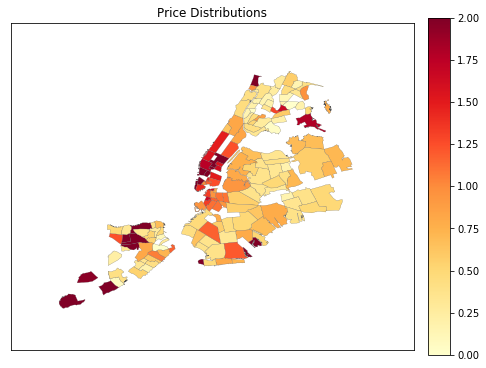

In [91]:
# Price Geometry Distribution 

prices = listings_detail[["neighbourhood","price","reviews_per_month"]].groupby(["neighbourhood"]).price.mean()
priceMap = dict(prices)

max_ = max(priceMap.values())
min_ = min(priceMap.values())
def norm_transform(price):
    return (price-min_)/( 250 - min_)#Hard Coding Truncature Here at 250 USD here to see a more meaningful result

###############SET UP LIMITS#########################
mp = nbgeo.geometry.loc[101]
cm = plt.get_cmap('YlOrRd')
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = mp.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 20 * w, maxx + 5 * w)
ax.set_ylim(miny - 10 * h, maxy + 8 * h)
ax.set_aspect(1)

###############ADD NEIGHBOURS#########################
for i in range(len(nbgeo.geometry)):
    patches = []
    mp = nbgeo.geometry.loc[i]
    nb = nbgeo.neighbourhood.loc[i]
    try:
        price = priceMap[nb]
    except:
        continue
    for idx, p in enumerate(mp):
        colour = cm(norm_transform(price))
        patches.append(PolygonPatch(p, fc=colour, ec='#555555', lw=0.2, alpha=1., zorder=1))
        ax.add_collection(PatchCollection(patches, match_original=True))

###############DRAW##################################
ax.set_xticks([])
ax.set_yticks([])
plt.title("Price Distributions")
plt.tight_layout()
##!!!!!! need to get color bar values correct
ax  = fig.add_axes([1,0.11,0.05,0.78])
norm = mpl.colors.Normalize(vmin=0,vmax=2)
cb1  = mpl.colorbar.ColorbarBase(ax,cmap=cm,norm=norm,orientation='vertical')

plt.show()

#### Popularity
We are defining popularity in terms of availibilty, meaning more popular airbnb's have less availability and less popular ones have more

In [38]:
#Change t and f to 1 and 0 
calendar_detail.available=calendar_detail.available.map(dict(t=1, f=0))

In [93]:
#Merge calendar details with listing details by listing_id to get the neighborhood group of each listing
cdmergels=pd.merge(calendar_detail, ls, left_on='listing_id', right_index=True, how='left')

In [71]:
cdmergels['available'].groupby(cdmergels['neighbourhood_group']).sum()
#Number of availibilities by neighborhood - higher means less popular

neighbourhood_group
Bronx             10981
Brooklyn         252356
Manhattan        261394
Queens            43330
Staten Island      7211
Name: available, dtype: int64

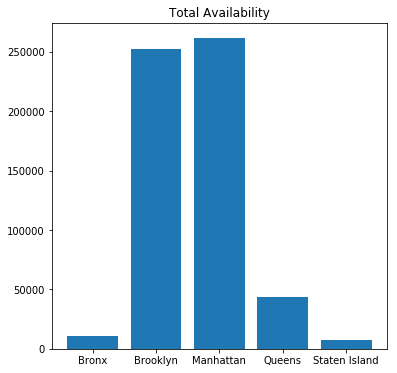

In [94]:
# Total Availability
avail_group = cdmergels[["neighbourhood_group","available"]].groupby(["neighbourhood_group"]).available.sum()
plt.figure(figsize = (6,6))
plt.bar(range(len(avail_group.values)),avail_group.values)
plt.xticks(range(len(avail_group.values)),list(avail_group.index))
plt.title("Total Availability");

This can be misleading since there are way more Airbnbs in general in Manhattan and Brooklyn, so there will therefore be more available rooms. Maybe we can make this relative to the amount of Airbnb's there are so that we get an average available days per Airbnb by neighborhood.

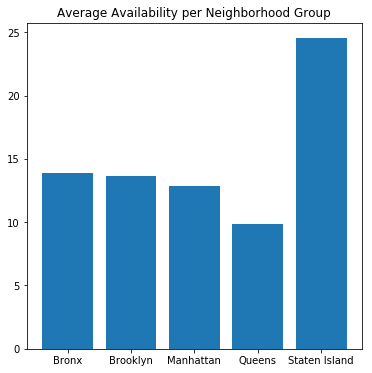

In [95]:
# Average Availability
avail_group = (cdmergels[["neighbourhood_group","available"]].groupby(["neighbourhood_group"]).available.sum())/(ls['host_id'].groupby(ls['neighbourhood_group']).count())
plt.figure(figsize = (6,6))
plt.bar(range(len(avail_group.values)),avail_group.values)
plt.xticks(range(len(avail_group.values)),list(avail_group.index))
plt.title("Average Availability per Neighborhood Group");

This plot paints a much different picture which is much more accurate. For the amount of Airbnb's there are in Staten Island, they are on average more available than any other neighbourhood group. This is the availability relative to the amount of Airbnb's in the area. The Bronx, Brooklyn, and Manhattan have VERY similar averages which is interesting. Queens seems to be the more popular since it has the least availability.

I used the values below to check that the average was calculated properly which it was. It is the amount of available days per neighbourhood group divided by the total number of Airbnbs in each neighborhood group - to get the average amount of available days per Airbnb within each neighborhood group (borough)

In [78]:
avail_group #Used this to check that this is the amount of available days for each neighborhood group 
            #divided by the amount of Airbnbs per ng - it's correct.

neighbourhood_group
Bronx            13.882427
Brooklyn         13.663021
Manhattan        12.832302
Queens            9.865665
Staten Island    24.527211
dtype: float64

### Question 2: 
Do factors such as number of minimum nights, cancellation policy, instant bookable, and house rules affect the popularity of an Airbnb?

### Question 3: 
How important are reviews and how much do they affect whether or not an Airbnb gets booked?

### Question 4: 
Do amenities, access (entire apartment vs private room), room type (private vs shared), transit, or number of guests significantly impact whether or not an Airbnb is booked?

### Visualize Data on Map
- What areas are most popular? why?

#### Number of Airbnbs by Neighbourhood

In [89]:
#Use host id since there are no missing - meaning we get every record when counting
ls['host_id'].groupby(ls['neighbourhood_group']).count()

neighbourhood_group
Bronx              791
Brooklyn         18470
Manhattan        20370
Queens            4392
Staten Island      294
Name: host_id, dtype: int64

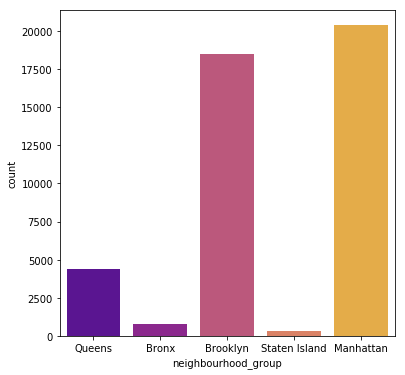

In [88]:
#https://www.kaggle.com/darkrubiks/nyc-airbnb-exploratory-analysis
#Amount of Airbnbs by borough
plt.figure(figsize=(6,6))
ax = sns.countplot(ls["neighbourhood_group"], palette="plasma" ) 

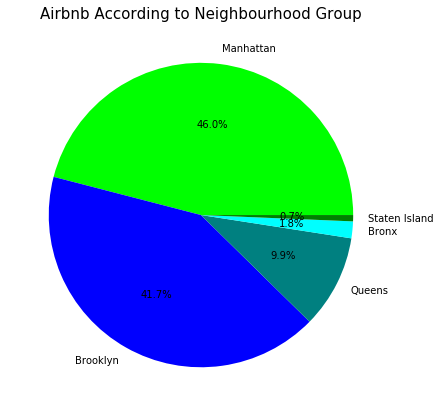

In [87]:
labels = ls.neighbourhood_group.value_counts().index
colors = ['lime','blue','teal','cyan','green']
explode = [0,0,0,0,0]
sizes = ls.neighbourhood_group.value_counts().values

plt.figure(0,figsize = (7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Airbnb According to Neighbourhood Group',color = 'k',fontsize = 15)
plt.show()

Things to explore later

In [86]:
ld=listing_details[['guests_included','extra_people','minimum_nights','listing_url','house_rules','cancellation_policy','instant_bookable','amenities','price','weekly_price','monthly_price','room_type','neighbourhood','reviews_per_month','longitude','latitude']]

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

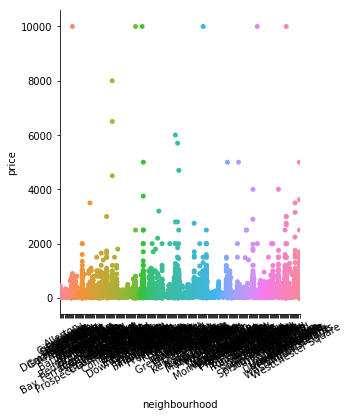

In [42]:
g=sns.catplot(x = "neighbourhood", y = "price", data=ls)
g.set_xticklabels(rotation=30)
#sns.set(rc={'figure.figsize':(40,20)})
